## AICとは
- 統計モデルを評価するための指標
- 小さい程良い
- AICを使うとテストデータを使わず、学習データだけで（ある程度）学習が可能

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [2]:
# AICの計算
def AIC(model, X, y):
    from sklearn.metrics import mean_squared_error
    from math import log, pi
    n = len(y)
    mse = mean_squared_error(y, model.predict(X))
    k = model.coef_.shape[0] + int(model.fit_intercept)
    d = max(1e-308, 2*pi*mse)
    return n*(log(d) + 1) + 2*k

In [3]:
# サンプルでAICの計算
lr1 = LinearRegression().fit(X, y)
aic1 = AIC(lr1, X, y)
aic1

3025.6767200074596

In [4]:
X2, y2 = [[2, -1, 3],[-1, 2, -2]], [1,0]
lr2 = LinearRegression().fit(X2, y2)
aic2 = AIC(lr2, X2, y2)
aic2

-1408.3924172843322

#### AICの計算式

$-2\times{log L} +2\times{k}$

- ただし、最大尤度をL、「説明変数と定数項の数」をkとする
- 最大尤度は各データの起こりやすさの積
- $-2\times{log L}$は当てはまりの良さを評価
- $2\times{k}$はパラメータの少なさを評価

上の式は誤差が正規分布に従うものとして次の式に置換できる

$AIC = n\times{(log (2\times{\pi}\times{MSE}) + 1) + 2\times{k}}$

- ただし、nはデータ数、MSEは平均二乗誤差

In [9]:
# AICの計算式
def AIC(model, X, y):
    from sklearn.metrics import mean_squared_error
    from math import log, pi
    n = len(y)
    mse = mean_squared_error(y, model.predict(X))
    # int(model.fit_intercept)は、定数項がある場合に1、ない場合に0になる。
    k = model.coef_.shape[0] + int(model.fit_intercept)
    # dが0だとlog(d)がエラーになるので、1e-308以上にする。
    d = max(1e-308, 2 * pi * mse)
    return n * (log(d) + 1) + 2 * k

In [10]:
# サンプルでAICの計算
lr1 = LinearRegression().fit(X, y)
aic1 = AIC(lr1, X, y)
aic1

3025.6767200074596

In [11]:
# ダミーデータでAICの計算
X2, y2 = [[2, -1, 3], [-1, 2, -2]], [1, 0]
lr2 = LinearRegression().fit(X2, y2)
aic2 = AIC(lr2, X2, y2)
aic2

-1408.3924172843322

## lru_cacheの使い方
- Last Recently Usedの略
- 直近で使われていないデータを最初に捨てるキャッシュアルゴリズム
- 使い方：関数に`@lru_cache(maxsize=1024)`を追加

In [12]:
from functools import lru_cache

In [13]:
# キャッシュなしで実行
class Fibonacci:
    count = 0
    def fib(self, n):
        Fibonacci.count += 1
        return n if n < 2 else self.fib(n -1) + self.fib(n - 2)

In [14]:
Fibonacci().fib(30)
count1 = Fibonacci.count
count1

2692537

In [15]:
# キャッシュありで実行
class Fibonacci:
    count = 0
    @lru_cache(maxsize=1024)
    def fib(self, n):
        Fibonacci.count += 1
        return n if n < 2 else self.fib(n - 1) + self.fib(n - 2)

In [16]:
Fibonacci().fib(30)
count2 = Fibonacci.count
count2

31

## ステップワイズ法
- たくさんの説明変数の中から汎化性能の高い説明変数の組み合わせを求める、アルゴリズム
- 変数増減法: ステップワイズ法の一つ。からの状態から追加と削除を繰り返す

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from functools import lru_cache

In [19]:
# ステップワイズ法のサブルーチン
# 頭に_をつけると非公開であることを表す
def _calc_best(calc_aic, best, N, is_add):
    found, cur = False, best
    for i in range(N):
        key = (best[1] | {i}) if is_add else (best[1] - {i})
        v = calc_aic(tuple(key))
        if v < cur[0]:
            cur = v, key
    if cur[0] < best[0]:
        found, best = True, cur
    return found, best

In [20]:
# ステップワイズ法
def stepwise(X, y, fit_intercept=True, cv=None):
    @lru_cache(maxsize=1024)
    def calc_aic(sel):
        X_ = X[:, sel]
        return cross_val_score(model.fit(X_, y), X_, y,
                              scoring=AIC, cv=cv).mean()
    model = LinearRegression(fit_intercept)
    N = X.shape[1] # 説明変数数
    best = 1e308, set() # 最良のAICと選択
    found = True
    while found and len(best[1]) < N:
        found, best = _calc_best(calc_aic, best, N, True)
        found2 = True
        while found2 and len(best[1]) > 1:
            found2, best = _calc_best(calc_aic, best, N, False)
            found |= found2
    return best[0], list(best[1])

In [21]:
# ボストン市住宅価格データで変数選択
aic, sel = stepwise(X.values, y, cv=6)
aic, sel

(517.1135458604272, [10, 11, 12, 5])

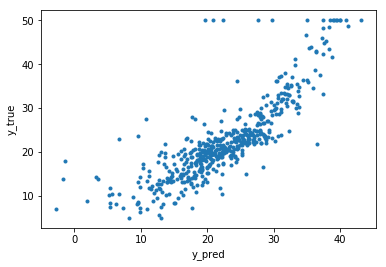

In [22]:
# 真値と予測値の散布図
X_sel = X.iloc[:, sel]
lr = LinearRegression().fit(X_sel, y)
y_pred = lr.predict(X_sel)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.plot(y_pred, y, '.')

In [23]:
X_sel.columns

Index(['PTRATIO', 'B', 'LSTAT', 'RM'], dtype='object')

### ステップワイズ法（変数増減法の手順）
1. 説明変数候補を空にする
2. 説明変数候補に新たな説明変数を1つ追加したとき、最も評価値（AIC）が良いものがあれば、追加します。
3. 説明変数候補から説明変数を1つ削除したとき、最も評価値（AIC）が良いものがあれば、削除します。
4. 削除が可能な間、ステップ3を繰り返します。
5. 更新がないか、全ての説明変数を選んだ場合は終了します。そうでない場合、ステップ2へ行きます。
